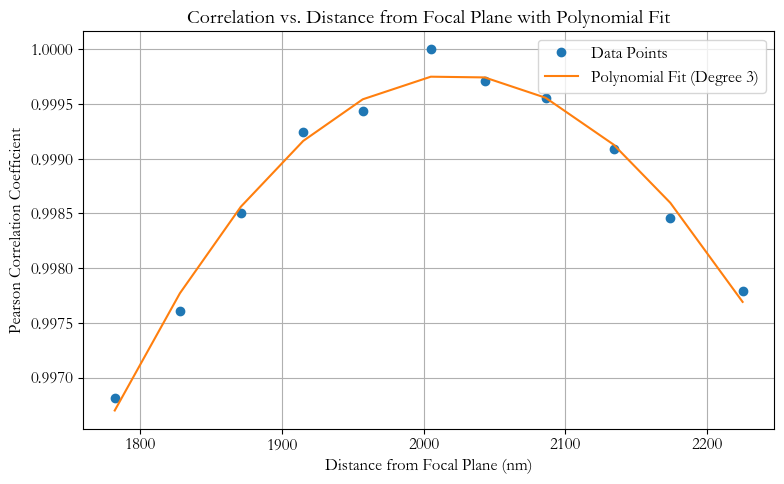

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 28 22:42:27 2025

@author: yanjie
"""

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fft import fft2, fftshift
from scipy.stats import pearsonr

# Directory and filenames
base_path = r"D:\bead image\Beadimages\Beadimage1"
files = [
    f for f in os.listdir(base_path)
    #提取开头为Moving结尾为.png的文件
    if f.startswith("Moving") and f.endswith(".png")
]

# Function to extract distance, handles potential errors, and returns filename and distance
def extract_distance_and_filename(fname):
    #匹配结构为“-数字nm”的文件
    match = re.search(r'-(\d+)nm', fname)
    if match:
        #.group(1) 表示获取正则表达式中第一个括号内匹配的内容，.group(0)返回整个匹配的字符串。 
        #在正则表达式 r'-(\d+)nm' 中：- (\d+) 是第一个（也是唯一一个）捕获组
        distance = int(match.group(1))
        return fname, distance
    else:
        return fname, None  # Return None for distance if not found

# Sort files based on extracted distance
#将files中的文件名分别放进函数里，返回文件名和距离，并组成新列表
files_with_distances = [extract_distance_and_filename(f) for f in files]
#过滤含有None的文件名和距离
files_with_distances = [
    (fname, distance) for fname, distance in files_with_distances if distance is not None
]  # Filter out files where distance wasn't found.
#key为关键字，lambda为匿名函数，x为输入，x[1]为第二个参数，即距离
#这里取出距离作为排序依据，在原列表中直接修改
files_with_distances.sort(key=lambda x: x[1])  # Sort by distance
#从文件名，距离组成的列表中取出文件名，组成新列表
sorted_files = [fname for fname, _ in files_with_distances]  # extract sorted filenames

# Specify reference filename
#参考微珠的文件名
ref_filename = "MovingBead-0_-2005nm.png"

# Get the index of the reference image
try:
    ref_index = sorted_files.index(ref_filename)
except ValueError:
    raise ValueError(f"{ref_filename} not found in file list.")

# Define window size
window_size = 5

# Safely get the subset of files
#只分析参考图像( ref_index )前后各5张图像（共11张），而不是处理全部图像。(带有边界保护)
start_index = max(ref_index - window_size, 0)
end_index = min(ref_index + window_size + 1, len(sorted_files))
selected_files = sorted_files[start_index:end_index]

# Reference image
ref_img = Image.open(os.path.join(base_path, ref_filename)).convert("L")

# Determine minimum common shape across all images
#.size获得(width, height), [::-1]将其反转，变成(height, width)
shapes = [Image.open(os.path.join(base_path, f)).convert("L").size[::-1] for f in sorted_files]
#s[0]取每个shape的高度,s[1]取每个shape的宽度
min_shape = (min(s[0] for s in shapes), min(s[1] for s in shapes))

# Crop and FFT the reference image
#保证所有图像的尺寸一致
ref_img_cropped = np.array(ref_img)[:min_shape[0], :min_shape[1]]
#fft2进行二维傅里叶变换，fftshift将零频率分量移到图像中心
ref_fft = fftshift(fft2(ref_img_cropped))

# High-pass filter function
def high_pass_filter(img_fft, threshold_ratio=0.005):
    # 获取频谱图的高度和宽度
    h, w = img_fft.shape
    # 计算中心点坐标（FFT移位后的中心）
    cx, cy = w // 2, h // 2
    # 计算滤波半径（基于图像尺寸的比例）
    radius = int(min(cx, cy) * threshold_ratio)
    # 生成二维网格坐标（X, Y），用于计算每个像素到中心的距离
    """
X = [[0 1 2 3]
     [0 1 2 3] 
     [0 1 2 3]]
Y = [[0 0 0 0]
     [1 1 1 1]
     [2 2 2 2]] 
    """
    Y, X = np.ogrid[:h, :w]
    # 计算每个像素到中心的距离（欧几里得距离）
    dist_from_center = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
    # 创建一个布尔掩码，距离大于半径的像素为True，否则为False
    mask = dist_from_center >= radius
    # 将掩码应用于频谱图，将距离大于半径的像素保留，其他像素置零
    return img_fft * mask

ref_fft_filtered = high_pass_filter(ref_fft)

# Extract distance from filename
def extract_distance(fname):
    match = re.search(r'-(\d+)nm', fname)
    return int(match.group(1)) if match else None



# Compute correlation coefficients
results = []
for fname in selected_files:
    img = Image.open(os.path.join(base_path, fname)).convert("L")
    img_cropped = np.array(img)[:min_shape[0], :min_shape[1]]
    img_fft = fftshift(fft2(img_cropped))
    img_fft_filtered = high_pass_filter(img_fft)

    # Flatten and compute Pearson correlation
    # ref_fft_filtered是个矩阵，这里将二维数组展平成一维数组以进行皮尔逊相关系数计算
    # r_value, _ 中的第二个参数为p-value，我们通常不需要它，所以用下划线 _ 来忽略它。
    r_value, _ = pearsonr(ref_fft_filtered.flatten().real, img_fft_filtered.flatten().real)
    distance = extract_distance(fname)
    if distance is not None:
        results.append((distance, r_value))

# Sort and save results
#按第一个元素x[0],也就是距离排序
results.sort(key=lambda x: x[0])
# 将结果列表转换为Pandas DataFrame，方便后续处理
df_results = pd.DataFrame({
            "Distance (nm)": [x[0] for x in results],
            "Pearson r": [x[1] for x in results]
        })

# Polynomial fit
# 从DataFrame中提取距离和相关系数值(转为numpy数组)
distances = df_results["Distance (nm)"].values
correlations = df_results["Pearson r"].values
distances = np.array(distances, dtype=np.float64).flatten()
correlations = np.array(correlations, dtype=np.float64).flatten()
# You can adjust the degree of the polynomial (e.g., 3 for cubic, 4 for quartic)
# 进行3次多项式拟合（可调整degree值改变多项式次数）
degree = 3
coeffs = np.polyfit(distances, correlations, degree)
# 创建多项式函数对象
polynomial_fit = np.poly1d(coeffs)
fitted_correlations = polynomial_fit(distances) #get the fitted y values

# Plot
plt.figure(figsize=(8, 5))
plt.plot(distances, correlations, 'o', label='Data Points')  # Plot the original data points
plt.plot(distances, fitted_correlations, '-', label=f'Polynomial Fit (Degree {degree})')  # Plot the fitted line
plt.title("Correlation vs. Distance from Focal Plane with Polynomial Fit")
plt.xlabel("Distance from Focal Plane (nm)")
plt.ylabel("Pearson Correlation Coefficient")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
